## Trabalho 4
## Aplicaçao de Aprendizado de Máquina para Diagnóstico de Doença Cardiovascular
### Dorival Alves da Silva Junior  - 215076
### Ian Loron de Almeida - 198933
### Elisa Dell’Arriva - 135551
### Felipe De Carvalho Pereira - 230214


Importação das bibliotecas:


In [1]:
### https://www.kaggle.com/dileep070/heart-disease-prediction-using-logistic-regression
import numpy as np
import pandas as pd 
# classifier models:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
# scaler
from sklearn.preprocessing import StandardScaler
# split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
# matplot libs
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt 
# to reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
# scoring
from sklearn.metrics import fbeta_score, make_scorer
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report
# to classification report
from sklearn.model_selection import learning_curve
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

In [2]:
def plotRed3d(train, point_labels, main_title='dimensionality reduction using PCA'):
    dicColors = {0:'magenta', 1:'blue'}    
    label_color = [dicColors[c] for c in point_labels]

    x_label = 'X'
    y_label = 'Y'
    z_label = 'Z'
    title = main_title 

    # creating figure
    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection ="3d")

    # creating plot
    ax.scatter3D(train[:,0], train[:,1], train[:,2],c=label_color,alpha=0.8)

    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)

    ax.legend(labels=['healthy', 'with probable ddisease'])
    plt.grid(b=True)

    plt.suptitle(title, fontsize=20)  
    # plt.savefig(title + '.png')
    plt.show()

In [3]:
import warnings
# https://stackoverflow.com/questions/43162506/undefinedmetricwarning-f-score-is-ill-defined-and-being-set-to-0-0-in-labels-wi
warnings.filterwarnings('ignore')

In [4]:
def print_val_scores(model, X_train, y_train, scoring=['f1_weighted','f1_macro','recall_weighted',
                                                       'precision_weighted'], 
                     cv=10):
    _,__,f1_w,f1_m,r,p=cross_validate(model, X_train, y_train, cv=cv,
                       scoring=scoring).items()
    mean_f1_w = f1_w[1].mean(); sd_f1_w = f1_w[1].std()
    mean_f1_m = f1_m[1].mean(); sd_f1_m = f1_m[1].std()
    mean_r = r[1].mean(); sd_r = r[1].std()
    mean_p = p[1].mean(); sd_p = p[1].std()
    
    print("Classification report for classifier {}:\nparameters:\n".format(model) +
          "{}\nmean: {}, std deviation: {}\n\n".format(f1_w[0],mean_f1_w,sd_f1_w) +
          "{}\nmean: {}, std deviation: {}\n\n".format(f1_m[0],mean_f1_m,sd_f1_m) +
          "{}\nmean: {}, std deviation: {}\n\n".format(r[0],mean_r,sd_r) +
          "{}\nmean: {}, std deviation: {}\n\n".format(p[0],mean_p,sd_p))

In [5]:
def print_val_custom_score (model, X_train, y_train, 
                            scoring='f1_macro', 
                            cv=10):
    print("Classification report for classifier {}:\nparameters:\n".format(model))
    
    myReturn=cross_validate(model,X_train,y_train,cv=cv,scoring=scoring)
    _,__,metric_score=myReturn
    metric_score=myReturn[metric_score]
    mean = np.mean(metric_score)
    sd = np.std(metric_score)
    print("{}\nmean: {}, std deviation: {}\n\n".format(scoring,mean,sd))

In [6]:
def print_metrics(clf, X, y, prediction, label):
    print(f"Classification report for classifier {clf}:\n"
          f"{metrics.classification_report(y, prediction)}\n")
    disp = metrics.plot_confusion_matrix(clf, X, y)
    disp.figure_.suptitle(f"Confusion Matrix for {label}")

In [7]:
data=pd.read_csv('UCI_heart_disease.csv')
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Retirando valores nulos e NaN

In [8]:
data=data.dropna()
data=data[data.notnull()]
data=data.reset_index()
data.describe()

,index,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,151.000000,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,87.612784,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,0.000000,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,75.500000,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,151.000000,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,226.500000,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,302.000000,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [9]:
target='target' # "TenYearCHD"
y=data[target]
X=data.drop(target,axis=1)

Aplicação de Feature scaling e Redução de dimensionalidade

In [10]:
scaler = StandardScaler()
X=scaler.fit_transform(X)
pca = PCA(n_components=11)
X_reduced=pca.fit_transform(X)
print(float(pca.explained_variance_ratio_.sum()))

0.9089763454477225


Separação em conjunto de teste e treino

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.20, random_state = 200)

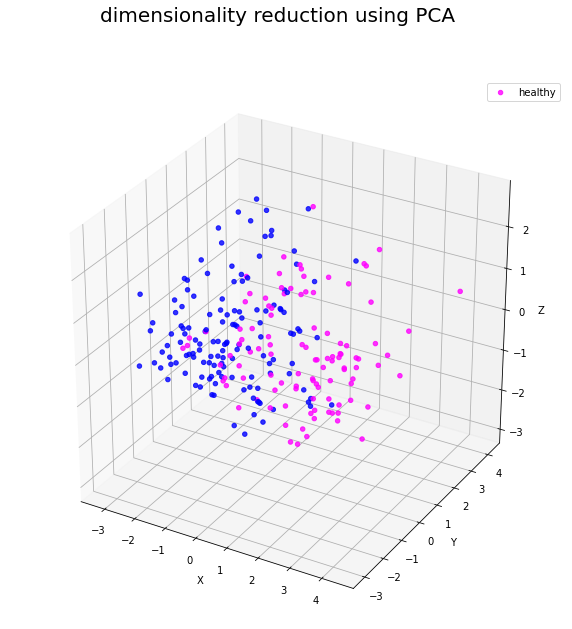

In [13]:
# print data distribution after dimentionality reduction
plotRed3d(X_train,y_train)

In [14]:
f_beta = make_scorer(fbeta_score, beta=2, average='weighted',zero_division=0)

Criação dos melhores hyperparametros

* clf_rfc -> Random Forest Classifier 
* clf_svm -> SVM
* clf_nb -> Gaussian Naive Bayes
* clf_lr -> Logistic Regression
* clf_nn -> Multi-layer Perceptron
* voting_clf_soft -> Soft Voting Classifier
* voting_clf_hard -> Hard Voting Classifier

In [15]:
# Criacao de grid para a Random Forest Classifier
max_depth = [int(x) for x in np.linspace(5, 100, num = 5)]
max_depth.append(None)

grid_rfc = {
    'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 500, num = 11)],
    'criterion': ['gini','entropy'],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'max_depth': max_depth,
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

In [16]:
clf_rfc = RandomForestClassifier()

In [17]:
#  Random search of parameters. Uses our shuffle selection cross validation, 
#  and search across "n_iter" different (shuffle) combinations, and use all available cores
rfc_search = RandomizedSearchCV(estimator = clf_rfc, param_distributions = grid_rfc, 
                               n_iter = 20, cv = 5, random_state=200, scoring=f_beta)

rfc_search.fit(X_train, y_train)
rfc_search.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 76,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 410}

In [18]:
rfc_search.best_score_

0.9167126632631948

In [19]:
best_clf_rfc = rfc_search.best_estimator_

In [20]:
print_val_custom_score(best_clf_rfc, X_train, y_train,f_beta)

Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=76, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=410,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False):
parameters:

make_scorer(fbeta_score, beta=2, average=weighted, zero_division=0)
mean: 0.9121794522150182, std deviation: 0.0757568247488085




SVM implementarion

In [21]:
clf_svm = make_pipeline(StandardScaler(), SVC())

In [22]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

C = [float(x) for x in np.linspace(start = 0.1, stop = 150.0, num = 10).astype(float)]
class_weight=['balanced', None]
kernel = ['linear', 'poly', 'rbf','sigmoid']
gamma = ['scale', 'auto']
decision_function_shape = ['ovo','ovr']
shrinking = [True, False]

grid_svm = {'svc__C': C,
                   'svc__kernel': kernel,
                   'svc__gamma': gamma,
                   'svc__class_weight':class_weight,
                   'svc__decision_function_shape': decision_function_shape,
                   'svc__shrinking': shrinking,
                   'svc__probability': [True]
           }

In [23]:
svm_search = RandomizedSearchCV(estimator = clf_svm, param_distributions = grid_svm, 
                               n_iter = 20, cv = 5, random_state=200, scoring=f_beta)

svm_search.fit(X_train, y_train)
svm_search.best_params_

{'svc__C': 66.72222222222221,
 'svc__class_weight': 'balanced',
 'svc__decision_function_shape': 'ovr',
 'svc__gamma': 'scale',
 'svc__kernel': 'linear',
 'svc__probability': True,
 'svc__shrinking': False}

In [24]:
best_clf_svm = svm_search.best_estimator_
svm_search.best_score_
print_val_custom_score(best_clf_svm,X_train,y_train,f_beta)

Classification report for classifier Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=66.72222222222221, break_ties=False, cache_size=200,
                     class_weight='balanced', coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='scale',
                     kernel='linear', max_iter=-1, probability=True,
                     random_state=None, shrinking=False, tol=0.001,
                     verbose=False))],
         verbose=False):
parameters:

make_scorer(fbeta_score, beta=2, average=weighted, zero_division=0)
mean: 0.9289013465617046, std deviation: 0.0465632080959289




In [26]:
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
var_smoothing = [float(1/10**x) for x in np.linspace(start=1,stop=15,num=16)]

grid_nb = {
    'var_smoothing': var_smoothing
}

In [27]:
clf_nb = GaussianNB()
nb_search = GridSearchCV(estimator = clf_nb, param_grid = grid_nb, 
                         cv = 5, scoring=f_beta)
nb_search.fit(X_train, y_train)
nb_search.best_params_

{'var_smoothing': 0.011659144011798317}

In [28]:
best_clf_nb = nb_search.best_estimator_
nb_search.best_score_
print_val_custom_score(best_clf_nb,X_train,y_train,f_beta)

Classification report for classifier GaussianNB(priors=None, var_smoothing=0.011659144011798317):
parameters:

make_scorer(fbeta_score, beta=2, average=weighted, zero_division=0)
mean: 0.9075675417529159, std deviation: 0.06703850600722204




In [29]:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

C=[float(x) for x in np.linspace(start=0.1,stop=3,num=21)]
grid_lr = {
    'C': C,
    'n_jobs': [None, -1],
    'multi_class': ['auto', 'ovr', 'multinomial'],
    'warm_start': [False,True]
}

In [30]:
clf_lr = LogisticRegression()

lr_search = RandomizedSearchCV(estimator = clf_lr, param_distributions=grid_lr, 
                                 n_iter=20, cv = 5, scoring=f_beta)
lr_search.fit(X_train, y_train)
lr_search.best_params_

{'C': 1.115, 'multi_class': 'auto', 'n_jobs': -1, 'warm_start': True}

In [31]:
best_clf_lr = lr_search.best_estimator_
lr_search.best_score_
print_val_custom_score(best_clf_lr,X_train,y_train,f_beta)

Classification report for classifier LogisticRegression(C=1.115, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=True):
parameters:

make_scorer(fbeta_score, beta=2, average=weighted, zero_division=0)
mean: 0.9288039733732989, std deviation: 0.0500940951617341




In [32]:
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

alpha=[float(x) for x in np.linspace(start=1e-5,stop=0.001,num=20)]
alpha.append(0.0001)
learning_rate_init=[float(x) for x in np.linspace(start=1e-4, stop=1, num=15)]
learning_rate_init.append(0.001)
max_iter = [int(x) for x in np.linspace(start=0,stop=1000,num=21)]
grid_nn = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': alpha,
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'learning_rate_init': learning_rate_init,
    'shuffle': [True, False],
    'max_iter': max_iter,
    'verbose': [True, False],
    'warm_start': [True, False]
}
#pprint(grid_nn)

In [33]:
clf_nn = MLPClassifier()

nn_search = RandomizedSearchCV(estimator = clf_nn, param_distributions=grid_nn, 
                                 n_iter=20, cv = 5, scoring=f_beta)
nn_search.fit(X_train, y_train)
nn_search.best_params_

A saída de streaming foi truncada nas últimas 5000 linhas.
Iteration 282, loss = 0.59644061
Iteration 283, loss = 0.59610056
Iteration 284, loss = 0.59576036
Iteration 285, loss = 0.59542002
Iteration 286, loss = 0.59507953
Iteration 287, loss = 0.59473889
Iteration 288, loss = 0.59439810
Iteration 289, loss = 0.59405717
Iteration 290, loss = 0.59371608
Iteration 291, loss = 0.59337485
Iteration 292, loss = 0.59303346
Iteration 293, loss = 0.59269193
Iteration 294, loss = 0.59235024
Iteration 295, loss = 0.59200841
Iteration 296, loss = 0.59166642
Iteration 297, loss = 0.59132429
Iteration 298, loss = 0.59098200
Iteration 299, loss = 0.59063956
Iteration 300, loss = 0.59029697
Iteration 301, loss = 0.58995423
Iteration 302, loss = 0.58961133
Iteration 303, loss = 0.58926829
Iteration 304, loss = 0.58892509
Iteration 305, loss = 0.58858174
Iteration 306, loss = 0.58823823
Iteration 307, loss = 0.58789458
Iteration 308, loss = 0.58755077
Iteration 309, loss = 0.58720680
Iteration 310, lo

{'activation': 'relu',
 'alpha': 1e-05,
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.8571571428571427,
 'max_iter': 300,
 'shuffle': False,
 'solver': 'sgd',
 'verbose': False,
 'warm_start': False}

In [34]:
best_clf_nn = nn_search.best_estimator_
nn_search.best_score_
print_val_custom_score(best_clf_nn,X_train,y_train,f_beta)

Classification report for classifier MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='adaptive',
              learning_rate_init=0.8571571428571427, max_fun=15000,
              max_iter=300, momentum=0.9, n_iter_no_change=10,
              nesterovs_momentum=True, power_t=0.5, random_state=None,
              shuffle=False, solver='sgd', tol=0.0001, validation_fraction=0.1,
              verbose=False, warm_start=False):
parameters:

make_scorer(fbeta_score, beta=2, average=weighted, zero_division=0)
mean: 0.9282882422815874, std deviation: 0.05390630041933681




In [35]:
clf_lr = best_clf_lr 
clf_rfc = best_clf_rfc
clf_nb = best_clf_nb
clf_svm = best_clf_svm
clf_nn = best_clf_nn

In [36]:
print('5 fold cross-validation')

labels = ['Logistic Regression','Random Forest Classsifier', 'Naive Bayes', 'SVM', 'Multi-layer Perceptron']
for clf, label in zip([clf_lr, clf_rfc,clf_nb, clf_svm,clf_nn], labels):

    scores = cross_val_score(clf, X_train, y_train,
                             cv=5, scoring=f_beta)

    print("f2 Validation: %0.3f (+/- %0.3f) [%s]" % (np.mean(scores), np.std(scores), label))

5 fold cross-validation
f2 Validation: 0.921 (+/- 0.033) [Logistic Regression]
f2 Validation: 0.917 (+/- 0.053) [Random Forest Classsifier]
f2 Validation: 0.913 (+/- 0.045) [Naive Bayes]
f2 Validation: 0.909 (+/- 0.039) [SVM]
f2 Validation: 0.929 (+/- 0.032) [Multi-layer Perceptron]


In [37]:
voting_clf_hard = VotingClassifier(estimators = [(labels[0], clf_lr),
                                                 (labels[1], clf_rfc),
                                                 (labels[2], clf_nb),
                                                 (labels[3], clf_svm),
                                                 (labels[4], clf_nn)],
                                  voting='hard')

In [38]:
voting_clf_soft = VotingClassifier(estimators = [(labels[0], clf_lr),
                                                 (labels[1], clf_rfc),
                                                 (labels[2], clf_nb),
                                                 (labels[3], clf_svm),
                                                 (labels[4], clf_nn)],
                                  voting='soft')

In [39]:
print('5 fold cross-validation')

labels = ['Logistic Regression','Random Forest Classifier', 'Naive Bayes', 'SVM','Multi-layer Perceptron', 
          'Voting Classifier - Hard', 'Voting Classifier - Soft']
for clf, label in zip([clf_lr, clf_rfc,clf_nb, clf_svm,clf_nb, voting_clf_hard, voting_clf_soft], labels):

    scores = cross_val_score(clf, X, y,
                             cv=5, scoring=f_beta,error_score='raise')

    print("f2 Validation: %0.3f (+/- %0.3f) [%s]" % (np.mean(scores), np.std(scores), label))

5 fold cross-validation
f2 Validation: 0.959 (+/- 0.047) [Logistic Regression]
f2 Validation: 0.916 (+/- 0.108) [Random Forest Classifier]
f2 Validation: 0.943 (+/- 0.044) [Naive Bayes]
f2 Validation: 0.952 (+/- 0.059) [SVM]
f2 Validation: 0.943 (+/- 0.044) [Multi-layer Perceptron]
f2 Validation: 0.949 (+/- 0.061) [Voting Classifier - Hard]
f2 Validation: 0.963 (+/- 0.049) [Voting Classifier - Soft]


Verificando o resultado obtido ( precision, recall, f1-score, accuracy, macro average, weighted average ) e suas respectivas matrix de confusão

Classification report for classifier LogisticRegression(C=1.115, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=True):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        32
           1       0.97      0.97      0.97        29

    accuracy                           0.97        61
   macro avg       0.97      0.97      0.97        61
weighted avg       0.97      0.97      0.97        61


Classification report for classifier RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=76, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurit

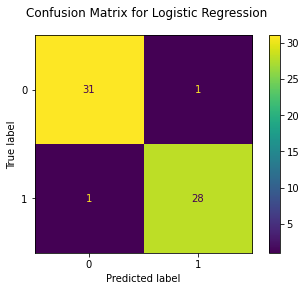

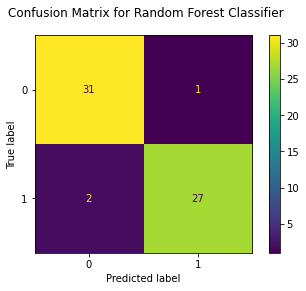

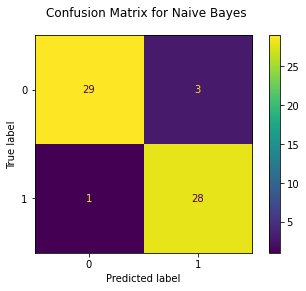

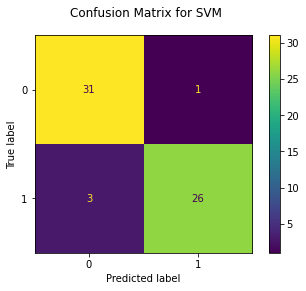

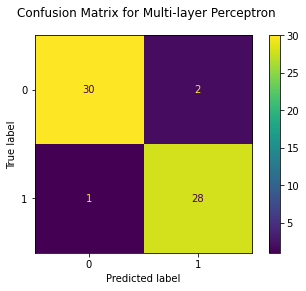

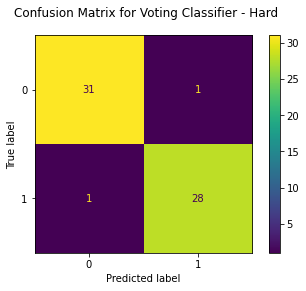

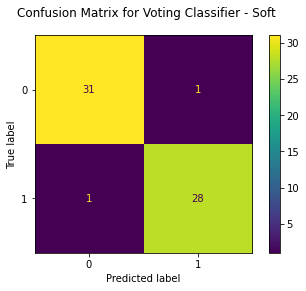

In [41]:
for clf, label in zip([clf_lr, clf_rfc,clf_nb, clf_svm, clf_nn, voting_clf_hard, voting_clf_soft], labels):
    clf.fit(X_train,y_train)
    prediction = clf.predict(X_test)
    print_metrics(clf,X_test,y_test,prediction,label)

Caso vc nao queira rodar tudo de novo, pode dar ctrl c+v nos grids e recuperar os melhores modelos assim:

In [42]:
# https://stackoverflow.com/questions/33110973/pass-a-dict-to-scikit-learn-estimator
grid_rfc={'n_estimators': 500,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': None,
 'criterion': 'gini',
 'bootstrap': True}

clf_rfc=RandomForestClassifier(**grid_rfc)

grid_svm={'svc__shrinking': False,
 'svc__probability': True,
 'svc__kernel': 'rbf',
 'svc__gamma': 'auto',
 'svc__decision_function_shape': 'ovo',
 'svc__class_weight': None,
 'svc__C': 0.1}

clf_svm = make_pipeline(StandardScaler(), SVC())
clf_svm.set_params(**grid_svm)

grid_nb={'var_smoothing': 0.1}
clf_nb=GaussianNB(var_smoothing= 0.1)

grid_lr={'warm_start': True, 'n_jobs': -1, 'multi_class': 'multinomial', 'C': 0.39}
clf_lr=LogisticRegression(**grid_lr)

grid_nn = {'activation': 'tanh',
 'alpha': 0.0008957894736842106,
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.28578571428571425,
 'max_iter': 250,
 'shuffle': True,
 'solver': 'sgd',
 'verbose': False,
 'warm_start': False}
clf_nn=MLPClassifier(**grid_nn)